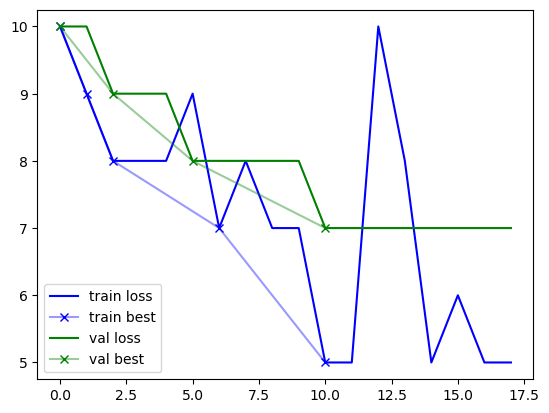

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

train_losses = np.array([10, 9, 8, 8, 8, 9, 7, 8, 7, 7, 5, 5, 10, 8, 5, 6, 5, 5])
losses_minimum = np.minimum.accumulate(train_losses)
change_indices = (np.roll(losses_minimum, 1) != losses_minimum).nonzero()[0]
best_losses = train_losses[change_indices]
val_losses = np.array([10, 10, 9, 9, 9, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7])
val_losses_minimum = np.minimum.accumulate(val_losses)
val_change_indices = (np.roll(val_losses_minimum, 1) != val_losses_minimum).nonzero()[0]
best_val_losses = val_losses[val_change_indices]

train_l, = plt.plot(train_losses, color='blue', label="loss")
train_mark, = plt.plot(change_indices, best_losses, color='blue', marker='x', linestyle='None')
train_lin,  = plt.plot(change_indices, best_losses, color='blue', linestyle='-', alpha=0.4)
val_l, = plt.plot(val_losses, color='green', label="val loss")
val_mark, = plt.plot(val_change_indices, best_val_losses, color='green', marker='x', linestyle='None')
val_lin,  = plt.plot(val_change_indices, best_val_losses, color='green', linestyle='-', alpha=0.4)
plt.legend([train_l, (train_mark, train_lin), val_l, (val_mark, val_lin)], ['train loss', 'train best', 'val loss', 'val best'], loc='lower left')
plt.show()

In [3]:
# Group checkpoints into folders
import glob
import os
import re


def get_run_name(path: str) -> str:
    # Remove "_best", "_epoch_*"
    name = os.path.basename(path)
    name = re.sub(r"_best.pt", "", name)
    name = re.sub(r"_epoch_\d+\.pt", "", name)
    return name


paths = glob.glob(os.path.join("../save/checkpoints/*.pt"))
for path in paths:
    run_name = get_run_name(path)
    dir_name = os.path.join("../save/checkpoints", run_name)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    os.rename(path, os.path.join(dir_name, os.path.basename(path)))

In [20]:
%load_ext autoreload
%autoreload 2

from src.deep_ad.config import Config

config = Config(root_dir="..", config_path="../default_config.yml")

config.batch_size = 64
config.train_epochs = 100
config.loss_type = "l1_norm"
config.init_weights = True
config.optim_lr = 2e-4

run_name = "8_class_10_1_batch_100_epochs_l1_norm_batch_64"
config.save(f"../save/checkpoints/{run_name}/config.yml")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from src.deep_ad.config import Config
from src.deep_ad.image import plot_losses
from src.deep_ad.model import DeepCNN
from src.deep_ad.save_manager import SaveManager
from src.deep_ad.trainer import create_optimizer

config = Config(root_dir="..", config_path="../default_config.yml")
save_manager = SaveManager(config)

model_best = DeepCNN(config, old_architecture=False).to(config.device)
optimizer_best = create_optimizer(model_best, config)
run_name = "test"
checkpoint_name = "epoch_100"
model_best, optimizer_best, train_losses, val_losses, epoch = SaveManager.load_checkpoint(
    model=model_best,
    optimizer=optimizer_best,
    path=SaveManager.get_checkpoint_path(config, run_name=run_name, name=checkpoint_name),
)
plot_losses(train_losses, val_losses, f"{run_name}/{checkpoint_name}")

In [6]:
# How many test labels are there? + Group per each class
import glob
import os

from src.deep_ad.config import Config

config = Config(root_dir="..", config_path="../default_config.yml")
classes = list(range(1, 11))
total_labels = 0
for cls in classes:
    class_paths = os.path.join(config.DAGM_raw_dir, f"Class{cls}", "Test", "Label", "*.PNG")
    num_labels = len(glob.glob(class_paths))
    total_labels += num_labels
    print(f"Class {cls}: {num_labels} labels")
print(f"Total labels: {total_labels}")

Class 1: 71 labels
Class 2: 84 labels
Class 3: 84 labels
Class 4: 68 labels
Class 5: 80 labels
Class 6: 67 labels
Class 7: 150 labels
Class 8: 150 labels
Class 9: 150 labels
Class 10: 150 labels
Total labels: 1054
